# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2021-03-01 16:55:21--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py.1’

cifar.py.1          100%[===================>]   2.34K  --.-KB/s    in 0s      

2021-03-01 16:55:21 (32.3 MB/s) - ‘cifar.py.1’ saved [2396/2396]



In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data") ##QUESTION val?

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


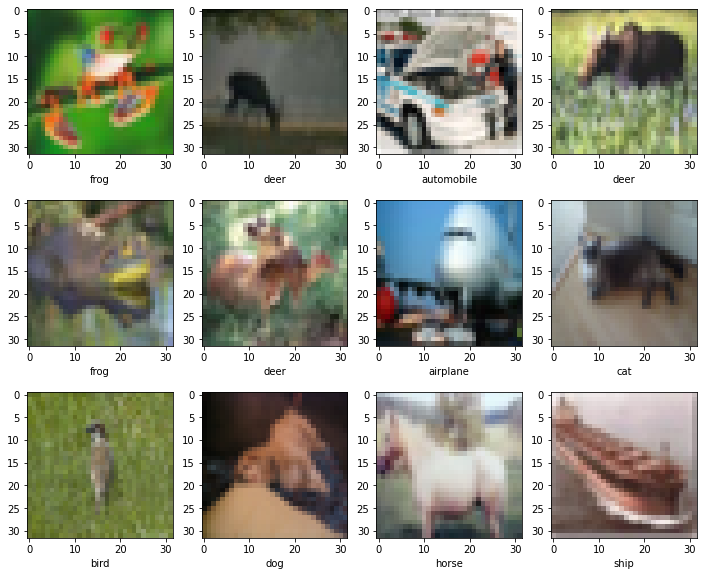

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('norm1', nn.BatchNorm2d(10))
model.add_module('flatten', Flatten())
model.add_module('dence1', nn.Linear(in_features=2250, out_features=100))
model.add_module('norm2', nn.BatchNorm1d(100))
model.add_module('relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('dence2', nn.Linear(in_features=100, out_features=10))



As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32) 
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3278, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 13.008s
  training loss (in-iteration): 	1.467945
  validation accuracy: 			52.09 %
Epoch 2 of 100 took 12.763s
  training loss (in-iteration): 	1.164167
  validation accuracy: 			60.53 %
Epoch 3 of 100 took 13.657s
  training loss (in-iteration): 	1.034120
  validation accuracy: 			59.64 %
Epoch 4 of 100 took 13.284s
  training loss (in-iteration): 	0.945430
  validation accuracy: 			50.73 %
Epoch 5 of 100 took 16.504s
  training loss (in-iteration): 	0.868170
  validation accuracy: 			57.08 %
Epoch 6 of 100 took 16.346s
  training loss (in-iteration): 	0.802027
  validation accuracy: 			61.37 %
Epoch 7 of 100 took 12.814s
  training loss (in-iteration): 	0.742494
  validation accuracy: 			61.93 %
Epoch 8 of 100 took 13.041s
  training loss (in-iteration): 	0.697544
  validation accuracy: 			62.81 %
Epoch 9 of 100 took 14.048s
  training loss (in-iteration): 	0.657732
  validation accuracy: 			55.96 %
Epoch 10 of 100 took 16.104s
  training loss (in-iteration): 	0.

KeyboardInterrupt: 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		61.91 %
Achievement unlocked: 70lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.




```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
batch_size = 32
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_size = int(train_loader.data.shape[0] * 0.8)
test_val_size = int(train_loader.data.shape[0] * 0.2)

train_dataset, test_val_dataset = torch.utils.data.random_split(train_loader, [train_size, test_val_size])

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

val_batch_gen = torch.utils.data.DataLoader(test_val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NotImplementedError: ignored

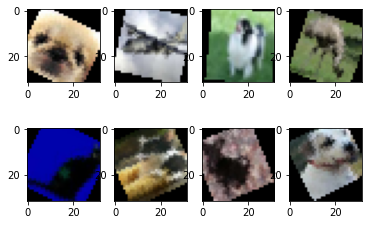

In [ ]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

In [ ]:
def compute_loss2(X_batch, y_batch):
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
import time
device = torch.device("cuda:0")
model = model.to(device)
train_loss = []
val_accuracy = []
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        # train on batch
        loss = compute_loss2(X_batch.to(device), y_batch.to(device))
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        y_batch = y_batch.detach().cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_batch_gen) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_batch_gen) // batch_size :]) * 100))

Epoch 1 of 100 took 37.247s
  training loss (in-iteration): 	1.697959
  validation accuracy: 			40.62 %
Epoch 2 of 100 took 37.534s
  training loss (in-iteration): 	1.595247
  validation accuracy: 			45.31 %
Epoch 3 of 100 took 37.592s
  training loss (in-iteration): 	1.540679
  validation accuracy: 			43.75 %
Epoch 4 of 100 took 37.590s
  training loss (in-iteration): 	1.484041
  validation accuracy: 			45.00 %
Epoch 5 of 100 took 37.642s
  training loss (in-iteration): 	1.530849
  validation accuracy: 			45.62 %
Epoch 6 of 100 took 37.492s
  training loss (in-iteration): 	1.438100
  validation accuracy: 			47.19 %
Epoch 7 of 100 took 37.647s
  training loss (in-iteration): 	1.485532
  validation accuracy: 			52.50 %
Epoch 8 of 100 took 37.502s
  training loss (in-iteration): 	1.544856
  validation accuracy: 			47.19 %
Epoch 9 of 100 took 37.549s
  training loss (in-iteration): 	1.426726
  validation accuracy: 			49.06 %
Epoch 10 of 100 took 37.674s
  training loss (in-iteration): 	1.

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(X_batch.to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    y_batch = y_batch.detach().cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		65.37 %
Achievement unlocked: 70lvl Warlock!
